In [42]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
from scipy.optimize import minimize
from scipy.stats import norm


In [44]:
def load_mfcc_timeseries(
    audio_path: str,
    sr: int = 32000,         
    n_mfcc: int = 20,
    n_fft: int = 2048,
    hop_length: int = 512,
    max_seconds: float = None,
) -> tuple[np.ndarray, int]:
    """
    Retourne X (T,p) = MFCC(t) avec p=n_mfcc.
    """
    y, sr_eff = librosa.load(audio_path, sr=sr, mono=True)
    if max_seconds is not None:
        y = y[: int(max_seconds * sr_eff)]

    mfcc = librosa.feature.mfcc(
        y=y, sr=sr_eff,
        n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length
    )  # (p,T)

    X = mfcc.T.astype(np.float64)  # (T,p)
    return X, sr_eff


def standardize_timeseries(X: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    """Centre-réduit chaque dimension (feature MFCC) pour stabiliser les calculs."""
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True)
    return (X - mu) / (sd + eps)


## Time-domain : Tr(|γ(k)|) et somme partielle

γ(k)=Cov(X_t, X_{t+k}) est une matrice p×p, et pour visualiser la mémoire longue,
on résume par Tr(|γ(k)|) (valeur absolue élément-par-élément, puis trace). 
Comme la trace ne prend que la diagonale, cela revient à sommer |Cov(X_{t,i}, X_{t+k,i})| sur i=1..p.

On trace :
- k ↦ Tr(|γ(k)|)
- Σ_{j≤k} Tr(|γ(j)|)  (la courbe qui monte “longtemps” = signature long memory)

In [47]:
def trace_abs_autocov(X: np.ndarray, max_lag: int = 250) -> tuple[np.ndarray, np.ndarray]:
    """
    Calcule Tr(|γ(k)|) pour k=1..max_lag, où γ(k)=Cov(X_t, X_{t+k}).
    Ici: Tr(|γ(k)|) = Σ_i |Cov(X_{t,i}, X_{t+k,i})| (diagonale).
    """
    T, p = X.shape
    Xc = X - X.mean(axis=0, keepdims=True)

    vals = np.zeros(max_lag, dtype=np.float64)
    for k in range(1, max_lag + 1):
        # Cov diag par dimension i : mean_t Xc[t,i]*Xc[t+k,i]
        prod = Xc[:-k, :] * Xc[k:, :]
        gamma_diag = prod.mean(axis=0)    # (p,)
        vals[k - 1] = np.sum(np.abs(gamma_diag))

    partial = np.cumsum(vals)
    return vals, partial


def plot_trace_abs_autocov(vals: np.ndarray, partial: np.ndarray, title_prefix: str = ""):
    k = np.arange(1, len(vals) + 1)

    plt.figure(figsize=(12,4))
    plt.plot(k, vals)
    plt.title(f"{title_prefix}Tr(|γ(k)|) vs lag k")
    plt.xlabel("k")
    plt.ylabel("Tr(|γ(k)|)")
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(k, partial)
    plt.title(f"{title_prefix}Partial sum Σ_{{j<=k}} Tr(|γ(j)|)")
    plt.xlabel("k")
    plt.ylabel("Σ Tr(|γ(j)|)")
    plt.show()


## Frequency-domain : estimateur GSE + total memory

le GSE (Gaussian semiparametric estimator) est définit via l’objectif :

L_m(d) = log det(G_hat(d)) - 2 * Σ_i d_i * (1/m) Σ_{j=1..m} log(λ_j)

avec
G_hat(d) = (1/m) Σ_j Re( Λ_j(d)^{-1} I(λ_j) Λ_j(d)^{-*} )

et λ_j = 2πj/T, I(λ_j)=y_j y_j^*, y_j = (1/sqrt(2πT)) Σ_t x_t e^{-iλ_j t}.
choix conservateur m = sqrt(T).

On reporte ensuite :
- d_hat (vecteur, dimension p)
- total memory : \bar d = 1^T d_hat
- normalized total memory : \bar d / p  (Table 1 du papier)
et on teste H0: \bar d = 0 vs H1: \bar d > 0 (p-value).


In [50]:
def _periodogram_real_parts(X: np.ndarray, m: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Construit Re(I(λ_j)) pour j=1..m (I = periodogram matrix).
    Retour:
      I_re: (m,p,p) matrices réelles
      lambdas: (m,) fréquences λ_j
    """
    T, p = X.shape
    Xc = X - X.mean(axis=0, keepdims=True)

    # FFT: F[j] = Σ_t Xc[t] e^{-i 2π j t / T}
    F = np.fft.fft(Xc, axis=0)
    js = np.arange(1, m + 1)
    lambdas = 2 * np.pi * js / T

    Y = F[js, :] / np.sqrt(2 * np.pi * T)  # (m,p) complex
    I = np.einsum("jp,jq->jpq", Y, np.conjugate(Y))  # (m,p,p) complex

    # Comme Λ^{-1} est réel à un facteur de phase global, Re(Λ^{-1} I Λ^{-*-1}) = D Re(I) D
    I_re = np.real(I)
    return I_re, lambdas


def _omega_from_G(G: np.ndarray, ridge: float = 1e-8) -> np.ndarray:
    """
    Ω (Shimotsu 2007) :
    Ω = 2 [ I_p + G ⊙ G^{-1} + (π^2/4)(G ⊙ G^{-1} - I_p) ].
    """
    p = G.shape[0]
    Gs = G + ridge * np.eye(p)
    Ginv = np.linalg.inv(Gs)
    had = Gs * Ginv  # Hadamard product ⊙ (elementwise)

    I = np.eye(p)
    Omega = 2.0 * (I + had + (np.pi**2 / 4.0) * (had - I))
    return Omega


def gse_multivariate(
    X: np.ndarray,
    m: int = None,
    bounds: tuple = (-0.49, 0.49),
    ridge_G: float = 1e-6,
    max_iter: int = 200,
) -> dict:
    """
    Estime d_hat via GSE + calcule total memory et p-value (test H0: bar_d=0).
    """
    T, p = X.shape
    if m is None:
        m = int(np.sqrt(T))  # choix conservateur du papier
    m = max(8, min(m, T // 2 - 1))

    I_re, lambdas = _periodogram_real_parts(X, m=m)
    log_lam = np.log(lambdas)
    mean_log_lam = float(log_lam.mean())

    def G_hat(d: np.ndarray) -> np.ndarray:
        # D_j = diag(λ_j^{d_i}); (phase globale s'annule)
        G = np.zeros((p, p), dtype=np.float64)
        for j in range(m):
            scales = np.exp(d * log_lam[j])  # λ_j^{d_i}
            Gj = (scales[:, None] * I_re[j]) * scales[None, :]
            G += Gj
        G /= m
        G += ridge_G * np.eye(p)
        return G

    def objective(d: np.ndarray) -> float:
        G = G_hat(d)
        sign, logdet = np.linalg.slogdet(G)
        if sign <= 0:
            return 1e9
        # Eq.(6): Lm(d) = log det G_hat(d) - 2 Σ_i d_i * (1/m) Σ_j log λ_j
        return float(logdet - 2.0 * np.sum(d) * mean_log_lam)

    x0 = np.zeros(p, dtype=np.float64)
    bnds = [bounds] * p

    res = minimize(
        objective, x0=x0, method="L-BFGS-B", bounds=bnds,
        options={"maxiter": max_iter}
    )

    d_hat = res.x
    bar_d = float(np.sum(d_hat))
    norm_bar_d = float(bar_d / p)

    # p-value (one-sided) via asymptotic normality of total memory 
    G = G_hat(d_hat)
    Omega = _omega_from_G(G)
    Omega_inv = np.linalg.inv(Omega + 1e-8 * np.eye(p))

    ones = np.ones((p, 1))
    var_bar_d = float((ones.T @ Omega_inv @ ones) / m)  # Var(bar_d) ≈ (1^T Ω^{-1} 1)/m
    se_bar_d = np.sqrt(max(var_bar_d, 1e-18))
    z = bar_d / se_bar_d
    p_value = float(norm.sf(z))  # one-sided: P(N(0,1) >= z)

    return {
        "success": bool(res.success),
        "message": str(res.message),
        "T": T, "p": p, "m": m,
        "d_hat": d_hat,
        "bar_d": bar_d,
        "norm_bar_d": norm_bar_d,
        "z": float(z),
        "p_value": p_value,
    }


## Negative control 

on fait une expérience de permutation : si on détruit l’ordre temporel,
la total memory doit se concentrer près de 0 (donc pas de long memory).

Ici on fait 2 versions :
- permutation totale (détruit toute dépendance),
- block-shuffle (plus “fair” : conserve localement, détruit le long terme).

On compare :
- norm_bar_d (vraie séquence) vs distribution nulle
- p-value empirique = proportion(nulle >= vraie)


In [53]:
def permute_time(X: np.ndarray) -> np.ndarray:
    idx = np.random.permutation(X.shape[0])
    return X[idx]


def block_shuffle_time(X: np.ndarray, block_size: int = 64) -> np.ndarray:
    T = X.shape[0]
    n_blocks = int(np.ceil(T / block_size))
    blocks = [X[i*block_size : min((i+1)*block_size, T)] for i in range(n_blocks)]
    np.random.shuffle(blocks)
    return np.concatenate(blocks, axis=0)


def empirical_p_value(observed: float, null_samples: np.ndarray) -> float:
    null_samples = np.asarray(null_samples)
    return float((1.0 + np.sum(null_samples >= observed)) / (len(null_samples) + 1.0))


In [55]:
def analyze_one_track(
    audio_path: str,
    n_mfcc: int = 20,
    max_seconds: float = 240.0,   # 4 minutes par défaut
    max_lag: int = 250,
    n_null: int = 30,
    null_mode: str = "block",     # "permute" ou "block"
    block_size: int = 64,
):
    # 1) MFCC embedding 
    X_raw, sr_eff = load_mfcc_timeseries(
        audio_path, sr=32000, n_mfcc=n_mfcc,
        n_fft=2048, hop_length=512,
        max_seconds=max_seconds
    )
    X = standardize_timeseries(X_raw)

    print(f"FILE: {os.path.basename(audio_path)}")
    print(f"sr={sr_eff} | X shape (T,p)={X.shape} | duration_used≈{max_seconds}s")

    # 2) partial sum of Tr(|γ(k)|)
    vals, partial = trace_abs_autocov(X, max_lag=max_lag)
    plot_trace_abs_autocov(vals, partial, title_prefix="[Time-domain] ")

    # 3) GSE estimate +  p-value
    gse = gse_multivariate(X, m=None)
    print("\n[GSE Results]")
    print("success:", gse["success"], "| m:", gse["m"], "| message:", gse["message"])
    print("norm_total_memory (bar_d/p):", gse["norm_bar_d"])
    print("total_memory (bar_d):", gse["bar_d"])
    print("one-sided p-value (H0: bar_d=0):", gse["p_value"])
    print("first 10 d_hat:", np.round(gse["d_hat"][:10], 4))

    # 4) Negative control distribution
    null_stats = []
    for _ in range(n_null):
        if null_mode == "permute":
            X0 = permute_time(X)
        else:
            X0 = block_shuffle_time(X, block_size=block_size)

        g0 = gse_multivariate(X0, m=gse["m"])
        null_stats.append(g0["norm_bar_d"])

    null_stats = np.array(null_stats)
    p_emp = empirical_p_value(gse["norm_bar_d"], null_stats)

    print(f"\n[Negative control: {null_mode}]")
    print("null mean:", float(null_stats.mean()), "| null std:", float(null_stats.std()))
    print("empirical p-value:", p_emp)

    plt.figure(figsize=(10,4))
    plt.hist(null_stats, bins=20)
    plt.axvline(gse["norm_bar_d"])
    plt.title(f"Null distribution of normalized total memory ({null_mode})")
    plt.xlabel("norm_total_memory (bar_d/p)")
    plt.ylabel("count")
    plt.show()

    return {
        "audio_path": audio_path,
        "T": gse["T"], "p": gse["p"], "m": gse["m"],
        "norm_bar_d": gse["norm_bar_d"],
        "bar_d": gse["bar_d"],
        "p_value": gse["p_value"],
        "null_mode": null_mode,
        "empirical_p_value": p_emp
    }


Using: data/audio\Don_Giovanni.mp3.mp3
FILE: Don_Giovanni.mp3.mp3
sr=32000 | X shape (T,p)=(15001, 20) | duration_used≈240.0s


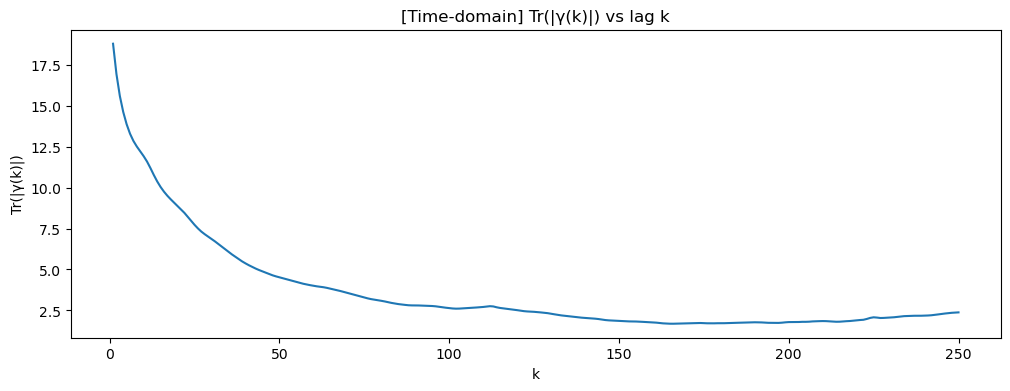

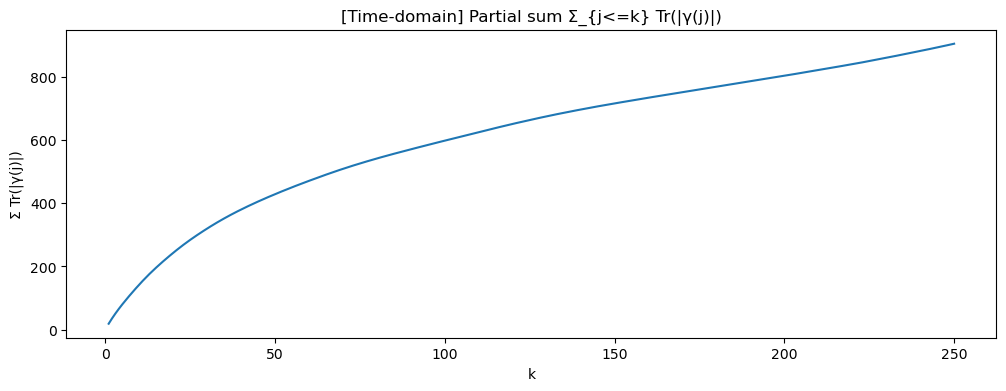

C:\Users\ebety\AppData\Local\Temp\ipykernel_44460\1649419266.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var_bar_d = float((ones.T @ Omega_inv @ ones) / m)  # Var(bar_d) ≈ (1^T Ω^{-1} 1)/m



[GSE Results]
success: True | m: 122 | message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
norm_total_memory (bar_d/p): 0.26047404471599866
total_memory (bar_d): 5.209480894319974
one-sided p-value (H0: bar_d=0): 2.502212755473057e-146
first 10 d_hat: [0.2562 0.2709 0.2593 0.2702 0.2647 0.2965 0.2883 0.2977 0.3095 0.2834]

[Negative control: block]
null mean: 0.0466050547041954 | null std: 0.00896852976687471
empirical p-value: 0.03225806451612903


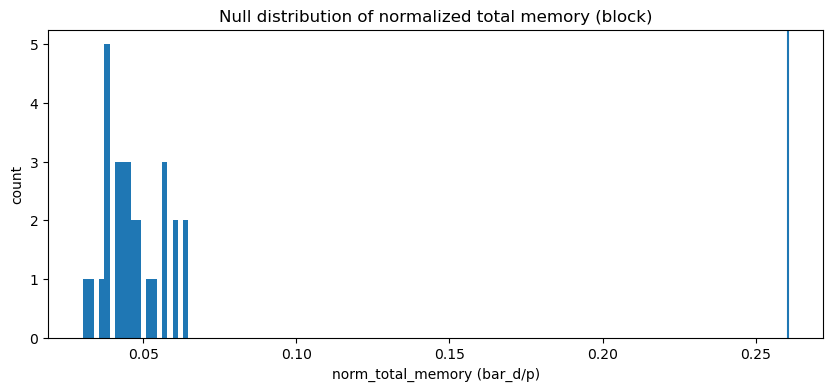

{'audio_path': 'data/audio\\Don_Giovanni.mp3.mp3',
 'T': 15001,
 'p': 20,
 'm': 122,
 'norm_bar_d': 0.26047404471599866,
 'bar_d': 5.209480894319974,
 'p_value': 2.502212755473057e-146,
 'null_mode': 'block',
 'empirical_p_value': 0.03225806451612903}

In [57]:
import glob, os

AUDIO_DIR = "data/audio"
candidates = []
for ext in ("*.wav","*.mp3","*.flac","*.ogg"):
    candidates += glob.glob(os.path.join(AUDIO_DIR, ext))


AUDIO_PATH = candidates[0]
print("Using:", AUDIO_PATH)

result = analyze_one_track(
    AUDIO_PATH,
    n_mfcc=20,
    max_seconds=240.0,
    max_lag=250,
    n_null=30,
    null_mode="block",
    block_size=64
)

result
